# An Employee Segmentation Model

## Abstract
This project shows how clusters of employees can help Salifort HR learn more about employee engagement.

The data that is used comes from the annual HR Employee Survey and is provided by a company named Salifort Motors.

The analysis shows that the `KMeans` algorithm is able to detect clusters of employees who left, however, due to the dimensionality of
the data, there is no clear structure in the clusters. To solve this, a dimensionality reduction
technique is performed prior to the implementation of the k-means algorithm. The results show
that the quality of the clusters significantly increases after applying a dimensionality reduction
technique. Moreover, three high-quality clusters of of employees who left.

### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# from kneed import KneeLocator


### Load the Data

We load in the data.

In [2]:
df0 = pd.read_csv("../../../../data/cleaned_hr_dataset.csv")

In [3]:
df0.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### Data Preparation and Features Selections

Before KMeans can be applied, some data preparations must be considered. 
Note, Exploratory Analysis have been performed on the data in [Salifort_Motors_project_lab](../Salifort_Motors_project_lab.ipynb) notebook. 

Therefore we will proceed with feature selection and model construction

#### Data Preparation and Preprocessing

* `salary` is categorical but it's ordinal i.e. the categories have a natural order. In this case, low, medium and high. Better not to dummy this column but rather to convert the levels to numbers 0-2.
* `department` is categorical.
* `promotion_last_5years` is a binary variable
* `work_accident` is a binary variable

The approach employed for this analysis would be to run the categorical variables through Multiple correspondence analysis (MCA)
while PCA on continuous features. This approached is based on a Kaggle discussion page [https://www.kaggle.com/general/19741](https://www.kaggle.com/general/19741).

#### Let's create a new feature variables `overworked` from `average_monthly_hours`.

In [4]:
df0["overworked"] = df0["average_monthly_hours"]

# Inspect max and min average monthy hours values
print(f"Max hours : {df0['overworked'].max()}")
print(f"Min hours : {df0['overworked'].min()}")
# df_enc = df_enc.drop(["average_monthly_hours"], axis=1)

Max hours : 310
Min hours : 96


In [5]:
df0["overworked"] = (df0["overworked"] > 200).astype("object")
# df0.drop(["average_monthly_hours"], axis=1, inplace=True)

#### Converting salary, promotion and work accident to category

In [6]:
col_to_convert = ["work_accident", "promotion_last_5years"]

df0.loc[:, col_to_convert] = df0.loc[:, col_to_convert].astype("object")



/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_76435/698029646.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 0 0 0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df0.loc[:, col_to_convert] = df0.loc[:, col_to_convert].astype("object")
/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_76435/698029646.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df0.loc[:, col_to_convert] = df0.loc[:, col_to_convert].astype("object")


In [7]:
# Converting object columns to categorical

catcols = df0.select_dtypes(["object"]).columns

df0[catcols] = df0[catcols].astype("category")
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11991 entries, 0 to 11990
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   satisfaction_level     11991 non-null  float64 
 1   last_evaluation        11991 non-null  float64 
 2   number_project         11991 non-null  int64   
 3   average_monthly_hours  11991 non-null  int64   
 4   tenure                 11991 non-null  int64   
 5   work_accident          11991 non-null  category
 6   left                   11991 non-null  int64   
 7   promotion_last_5years  11991 non-null  category
 8   department             11991 non-null  category
 9   salary                 11991 non-null  category
 10  overworked             11991 non-null  category
dtypes: category(5), float64(2), int64(4)
memory usage: 621.6 KB


In [8]:
# Make a copy of the data
df_enc = df0.copy()

# Encode the Salary variable as an ordinal numeric category
ordinal_mapping = {"low": 0, "medium": 1, "high": 2}
df_enc["salary"] = df_enc["salary"].map(ordinal_mapping)

#### In summary, here are the discrete and continuous features:

**Discrete features for MCA**
* work_accident
* promotion_last_5years
* department
* salary
* overworked


**Continuous features for PCA**

* satisfaction_level
* last_evaluation
* number_project
* tenure

### Variable Selection for Clustering Analysis

Let's find out the groups of employees who left. Left bunched them together based on their categorical and continuous variables in the dataset. 

Based on intuition and previous iteration of the project, we determined that `satisfaction_level` and `last_evaluation`, could potentially problematic in the form of data leakage.
We shall proceed with both anyways.

  

In [9]:
#Filter data
left_emp = df_enc[df_enc.left == 1]

# Select the continous feature variables
X_cont = df_enc[["satisfaction_level", 
                   "last_evaluation",
                   "number_project", 
                   "tenure",
                   "average_monthly_hours"
                ]]

# Select the categorical variables
X_cat = df_enc[["work_accident", "promotion_last_5years", "department", "salary", "overworked"]]

# Isolate the Outcome variable
y = df_enc["left"]


### Feature Scaling of continous variable

Because K-means uses distance between observations as the measure of similarity, it's important to scale data before modeling. 
This is to ensure that all variables have a mean of 0 and a variance of 1.

In [10]:
sc = StandardScaler()
X_std = sc.fit_transform(X_cont)

# Convert 2D array to Dataframe table
X_scaled = pd.DataFrame(X_std, columns=X_cont.columns, index=X_cont.index)

## KMeans Clustering without PCA or MCA


This section describes `K-means` clustering to uncover patterns of employee who left.

### K-means clustering using scikit-learn

In [11]:
# Fit K-means and evalaute inertia for different values of k.

# Assign a number from 2 to 25
num_clusters = [i for i in range(2,10)]

def kmeans_inertia(num_clusters:list[int], x_vals: np.ndarray)-> list[int]:
    """
    Accepts as argument, list of ints and data array.
    Fits a KMeans model where k = each value in the list of ints.
    Returns each k-value's inertia appened to a list
    """
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, n_init="auto", random_state=42).fit(x_vals)
        inertia.append(kms.inertia_)
    return inertia


def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, n_init="auto", random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


I have used the `n_init` argument to run the K-means with 20 initial cluster assignments (the default is 10). 

It is strongly recommend always running` K-means` clustering with a large value of `n_init`, such as 20 or 50, since otherwise an undesirable local optimum may be obtained.

In [12]:
# Return a list of inertia from k=2,tp k=10
inertias = kmeans_inertia(num_clusters, X_scaled)

# Take a look at first few inertia
inertias[:5]

[47212.26636153103,
 38606.39024698404,
 33677.43680137965,
 29445.206792163786,
 26754.85048444304]

### Using the elbow method to find the optimal number of clusters

One of the challenges in unsupervised learning is that we do not not know the definitive answer. Thus, to quanlity of the clustering, we need to use intrinsic metrics--such as the within-cluster SSE(distortion)--to compare the performance of different k-means clustering models.

Based on the with-cluster SSE, we can use a graphical tool, the so-called **elbow method**, to optimize the optimal number of clusters, _k_, for the given task. The idea behind the elbow method is to identify the value of _k_ where the distortion/inertia begins to increase most rapidly, which will become clearer if we plot the distortion for different values of k:

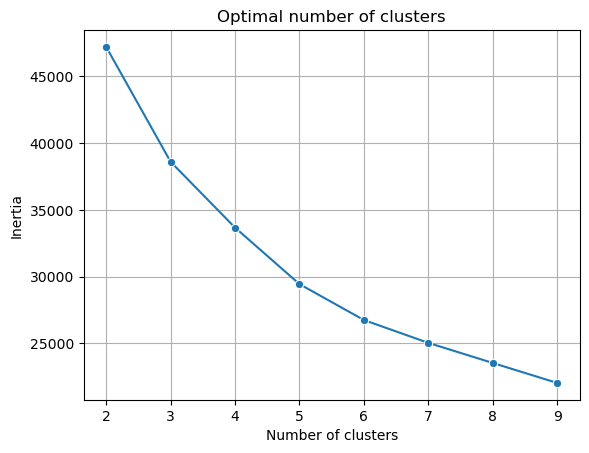

In [13]:
plot = sns.lineplot(x=num_clusters, y=inertias, marker="o")
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")
plot.set_title("Optimal number of clusters")
plot.grid();

From the plot, we can observe that the value of _k_ where the distortion/inertia begins to increase most rapidly is 11

Determining the elbow point in the inertia curve isn’t always straightforward as show in the plot. In instances where it difficult to choose the elbow point, Python package like [kneed](https://github.com/arvkevi/kneed), can be helpful to identify the elbow point programmatically:


In [14]:
from kneed import KneeLocator
kl = KneeLocator(
    range(2, 10), inertias, curve="convex", direction="decreasing"
)

n_cluster = kl.elbow
n_cluster

5

**Obersation**

With all the continous variables:

* The elbow point yield an optimum 9 `num_cluster`. This is quite large.
* We shall use the value to fit the model

In [15]:
kmean_9 = KMeans(n_clusters=n_cluster, n_init=15, random_state=42)
kmean_9.fit(X_scaled)

df_enc["cluster"] = kmean_9.labels_

print(f"Unique labels: {np.unique(kmean_9.labels_)}")


df_enc.head()

Unique labels: [0 1 2 3 4]


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary,overworked,cluster
0,0.38,0.53,2,157,3,0,1,0,sales,0,False,2
1,0.80,0.86,5,262,6,0,1,0,sales,1,True,0
2,0.11,0.88,7,272,4,0,1,0,sales,1,True,4
3,0.72,0.87,5,223,5,0,1,0,sales,0,True,0
4,0.37,0.52,2,159,3,0,1,0,sales,0,False,2


Lets look at the distribution of the `satisfaction_level` in these 9 groups using a boxplot. 

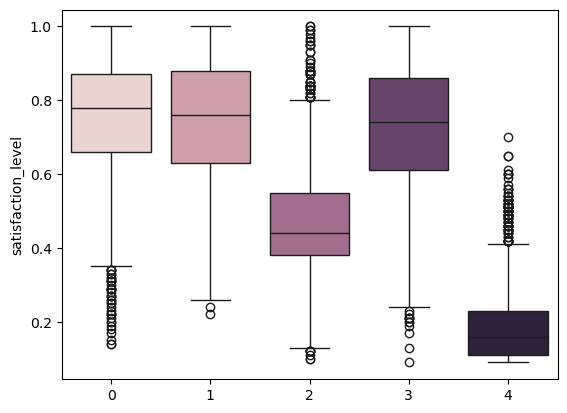

In [16]:
sns.boxplot(x=kmean_9.labels_, y=df_enc["satisfaction_level"], hue=kmean_9.labels_, legend=False);

We clearly see that the 0,1,2,4,5, and 8 have similar distributions of `satisfaction_level`
that are higher than the satisfaction in the (cluster 3, 6 and 7). 

We can evaluate performance of the clustering using silhouette score

In [17]:
silhouette_score(X_scaled, kmean_9.labels_, metric='euclidean')

0.22976712807480176

In [18]:
sil_score = kmeans_sil(num_clusters, X_scaled)


Typically, as we increase the value of K, we see improvements in clusters and what they represent until a certain point. We then start to see diminishing returns or even worse performance. We can visually see this to help make a decision on the value of k by using an elbow plot where the y-axis is a measure of goodness of fit and the x-axis is the value of k. 

<Axes: >

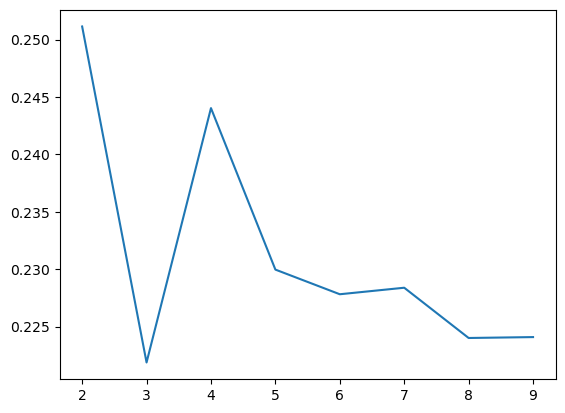

In [19]:
sns.lineplot(x=num_clusters, y=sil_score)

We typically choose the point where the improvements in performance start to flatten or get worse. We see k = 3 is probably the best we can do without overfitting. 

## KMeans Clustering with Dimensionality Reduction (PCA) and MCA

PAC helps us to identify patterns in data based on the correlation between features. It aims to find the direction of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimensions that the original one.

PCA directions are highly sensitive to data scaling, and we need to standardize the features prior to PCA if the features were measure on different scales

### Extracting the principal components step by step

1. Standardizing the data
2. Constructing the covariance matrix
3. Obtaining the eigenvalues and eigenvectors of the covariance matrix
4. Sorting the eigenvalues by decreasing order to rank the eigenvectors

#### 1. Standardizing the data:  Proprocess the win data

#### 2 & 3. Constructing the covariance matrix

In [20]:
X_std = X_scaled
cov_mat = np.cov(X_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(f"\nEigenvalues \n", eigen_vals)


Eigenvalues 
 [1.66810855 1.15361266 0.84129078 0.62900441 0.70840061]


#### 4.0 Sorting the eigenvalues by decreasing order to rank the eigenvectors
##### **Total and explained variance**
Since we want to reduce the dimensionality of our dataset by compressing it onto a new feature subspace, we only select the eigenvectors (principal components) that contains the most information(variance). The **eigenvalues** define the magnitude of the **eigenvectors**, we have to sort the eigenvalues in decreasing order.

Let's plot **varaiance explained ratio**

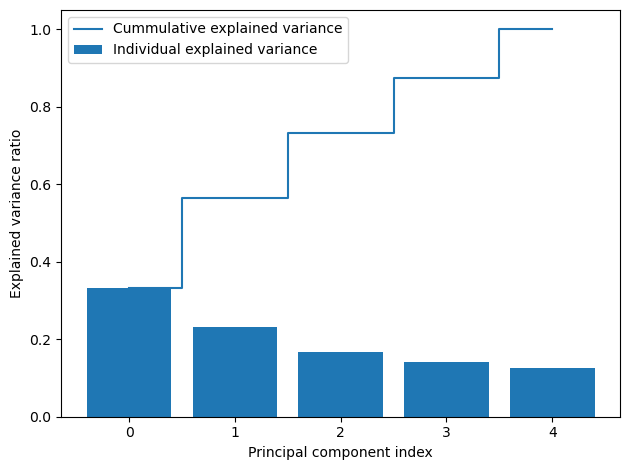

In [21]:
tot = sum(eigen_vals)
var_exp = [(i/tot) for i in sorted(eigen_vals, reverse=True)]

# cummulative sum of explained variance
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt

plt.bar(range(0, X_std.shape[1]), var_exp, align="center", label="Individual explained variance")
plt.step(range(0, X_std.shape[1]), cum_var_exp, where="mid", label="Cummulative explained variance")
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

The result of the plot shows that the first principal component explains the most variance in the dataset. It is however less than 4%.

### Principal component analysis in scikit learn

If we are interested in the explained variance ratios of the different principal components, we can
simply initialize the **PCA** class with the `n_components` parameter set to None, so all principal components
are kept and the explained variance ratio can then be accessed via the explained_variance_ratio_
attribute:


In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)

# pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_std)
pca.explained_variance_ratio_

array([0.33359389, 0.23070329, 0.16824412, 0.14166831, 0.12579039])

The values above are the explained variance ratios of the different principal components.

Note that we set `n_components=None` when we initialized the PCA class so that it will return all principal
components in a sorted order, instead of performing a dimensionality reduction.

### Assesing feature contributions

Lets assess the contributions of the original features to the principal components. This contributions are often called **loading**. 
In the preceeding code, we computed the factor loading for our own PCA implementation.

We can obtain the loading from a fitted `sklearn` PCA object in a similar manner.

In [23]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_std)
pca.explained_variance_ratio_

array([0.33359389, 0.23070329])

In [24]:
sklearn_loadings =  pca.components_.T * np.sqrt(pca.explained_variance_)

Where `pca.components_` represents the eigenvectors and `pca.explained_variance_` represents the eigenvalues

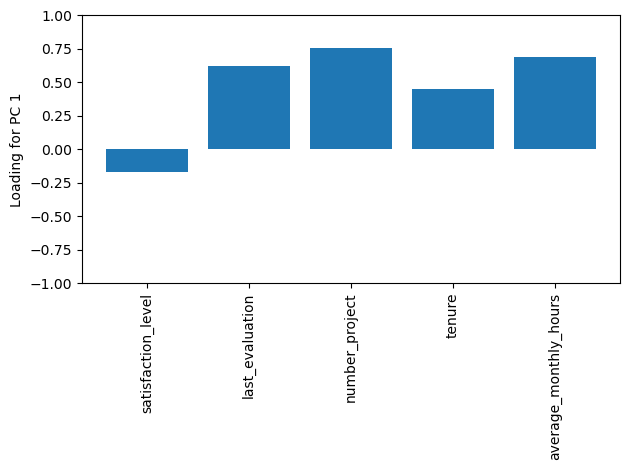

In [25]:

# X_ = df1.drop(["left"], axis=1)
ig, ax = plt.subplots()
ax.bar(range(X_std.shape[1]), sklearn_loadings[:, 0], align="center")
ax.set_ylabel("Loading for PC 1")
ax.set_xticks(range(X_std.shape[1]))
ax.set_xticklabels(X_scaled.columns, rotation=90)
# ax.set_xticklabels(X_.columns[1:], rotation=90)

plt.ylim([-1, 1])
plt.tight_layout()
plt.show()

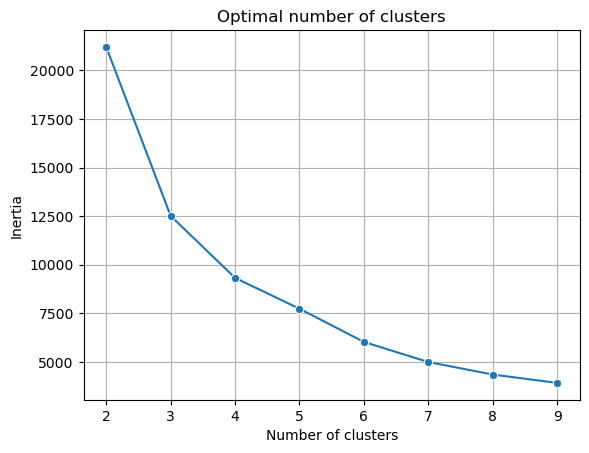

In [26]:
initia_pca = kmeans_inertia(num_clusters, X_pca)

plot = sns.lineplot(x=num_clusters, y=initia_pca, marker="o")
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Inertia")
plot.set_title("Optimal number of clusters")
plot.grid();

### Evaluate Both Algorithms with Silhouette score

To evaluate the quality of the clusters that are found in the data, and to draw conclusions
on the performance of both algorithms, the silhouette score will be used. This is a
performance indicator which is used to measure the validation and consistency of
clusters using the Euclidean distance

Lets evaluate the silhouette score using the `silhouette_score()` function. Silhouette scores are used to study the distance between clusters. 

Then, compare the silhouette score of each value of k, from 2 through 10. To do this, write a function called `kmeans_sil` that takes in `num_clusters` and `x_vals` (`X_scaled`) and returns a list of each k-value's silhouette score.

In [27]:
# Evaluate silhouette score.
# Write a function to return a list of each k-value's score.


def kmeans_sil(num_clusters, x_vals):
    """
    Accepts as arguments list of ints and data array. 
    Fits a KMeans model where k = each value in the list of ints.
    Calculates a silhouette score for each k value. 
    Returns each k-value's silhouette score appended to a list.
    """
    sil_score = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, n_init=10, random_state=42)
        kms.fit(x_vals)
        sil_score.append(silhouette_score(x_vals, kms.labels_))

    return sil_score


sil_score_pca = kmeans_sil(num_clusters, X_pca)


Next create a plot to show the relationship between `num_clusters` and `sil_score`

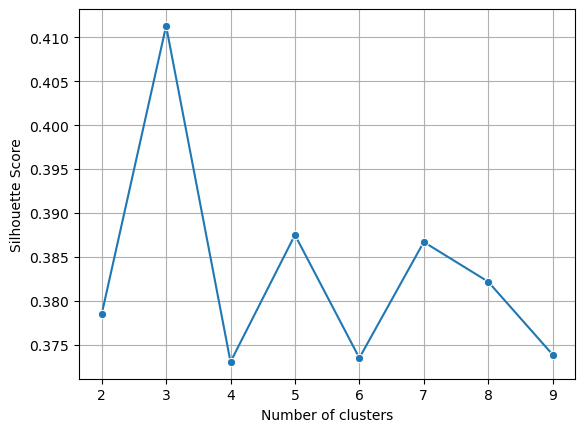

In [28]:
plot = sns.lineplot(x=num_clusters, y=sil_score_pca, marker="o")
plot.set_xlabel("Number of clusters")
plot.set_ylabel("Silhouette Score")
plot.grid()
# plot.set_xticks(range(0, 26, 2));

Silhoutte scores near 1 indicate that samples are far away from neighboring clusters. Scores close to 0 indicate that samples are on or very close to the decision boundary between two neighboring clusters.

The plot indicates that the silhouett score is closest to 1 when the data is partitioned into 3 clusters.

### Quantify the quality of clustering via Silhouette plots

To evaluate the quality of the clusters that are found in the data, and to draw conclusions
on the performance of the algorithm, the **`silhouette score`** will be used. This is a
performance indicator which is used to measure the validation and consistency of
clusters using the Euclidean distance. It can used to plot how tightly grouped the examples in the clusters are.

1. Calculate the **cluster cohesion**, the average distance between an example, $x^{(i)}$, and all other points in the same cluster.
2. Calculate the **cluster seperation**, $b(i)$, from the next closest cluster as the average distance between the example, $x^(i)$, and all examples in the nearest cluster.
3. Calculate the silhouette, $s^{(i)}$, as the difference between the cluster cohesion and seperation divided by the greter of the two

The silhouette score can only take values between -1 and 1 where a negative score
indicates that an individual datapoint is assigned to the wrong cluster. In contrast, a positive score indicates that the individual datapoint is
assigned to the right cluster. 

To eventually assess how well the clustering algorithm
performed as a whole, the average silhouette score for all datapoints is calculated. By
definition this value can only take values between -1 and 1 where a higher score means
a better structure of the clusters. A score of 0 indicates that the clusters are indifferent
and therefore, the clusters cannot be interpreted.

In [29]:
km = KMeans(n_clusters=3, # from the elbow plot
           init="k-means++",
           n_init=10,
           max_iter=300,
           tol=1e-04,
           random_state=0)
y_km = km.fit_predict(X_pca)

cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

silhouette_vals = silhouette_samples(X_pca, y_km, metric="euclidean")
silhouette_vals

array([0.61896916, 0.1928565 , 0.54529338, ..., 0.29327271, 0.32731316,
       0.06379904])

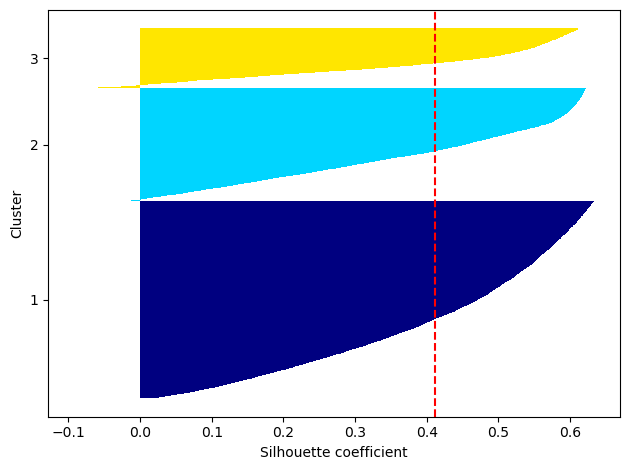

In [30]:
from matplotlib import cm


y_ax_lower, y_ax_upper = 0, 0
yticks = []

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor="none",
            color=color)
    yticks.append((y_ax_lower + y_ax_upper)/2.0)
    y_ax_lower += len(c_silhouette_vals)

silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.tight_layout()

**Observation**

* We can see in the plot, the three of silhouette coefficient is not close to zero and are approximately equally far away from the average silhouette score, which in this case, an indication of good clusttering. 

In [31]:
left_emp["cluster"] = kmean5.labels_
left_emp.head()

NameError: name 'kmean5' is not defined

## Observation

* With a silhouette score less than 0.5, the generally indicates suboptimal clustering performance. We could interpret as follows:

  - Poor separation between clusters
  - The chosen number of clusters may not be optimal
  - 
* The possible causes:
  - Chosen clustering algorithm may not be suitable
  - Incorrect number of clusters specified
  - Cause of dimensionality

## Actions to consider:

* Try different clustering algorithms
* Investigate if clustering is appropriate for your data
* Address possible cause of dimensionality with PCA


In plot above, we can see that, for example, `satisfaction level` has a negative correlation with the first principal component (approximately –0.3), whereas Las Evaluation has a positive correlation (approximately 0.54).
Note that a value of 1 describes a perfect positive correlation whereas a value of –1 corresponds to a
perfect negative correlation:

## Pipeline

The next code block uses the concept of [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline). The scikit-learn Pipeline class is a concrete implementation of the abstract idea of a machine learning pipeline.

The first step in pipeline will to implement the [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to perform dimensionality reduction

In [32]:

from sklearn.pipeline import Pipeline

preprocessor = Pipeline(
    [
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

Now that we’ve built a pipeline to process the data, we’ll build a separate pipeline to perform k-means clustering. We’ll override the following default arguments of the KMeans class:

In [33]:
# n_cluster = 7
clusterer = Pipeline(
   [
       (
           "kmeans",
           KMeans(
               n_clusters=3,
               init="k-means++",
               n_init=50,
               max_iter=500,
               random_state=42,
           ),
       ),
   ]
)

The Pipeline class can be chained to form a larger pipeline. Build an end-to-end k-means clustering pipeline by passing the "preprocessor" and "clusterer" pipelines to Pipeline:

In [34]:
pipe = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("clusterer", clusterer)
    ]
)

Calling ``.fit()`` with data as the argument performs all the pipeline steps on the data:

In [35]:
pipe.fit(X_std)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=3, n_init=50,
                                         random_state=42))]))])

In [36]:
labels = pipe["clusterer"]["kmeans"].labels_

Evaluate the performance by calculating the silhouette coefficient:

In [37]:
pipe["clusterer"]["kmeans"].inertia_

12514.726537785398

In [38]:
preprocessed_data = pipe["preprocessor"].transform(X_std)

predicted_labels = pipe["clusterer"]["kmeans"].labels_

silhouette_score(preprocessed_data, predicted_labels)

0.41128402318457147

Since we specified `n_components=2` in the PCA step of the k-means clustering pipeline, let's also visualize the data in the context of the true labels and predicted labels. 

Plot the results using a pandas DataFrame and the seaborn plotting library:

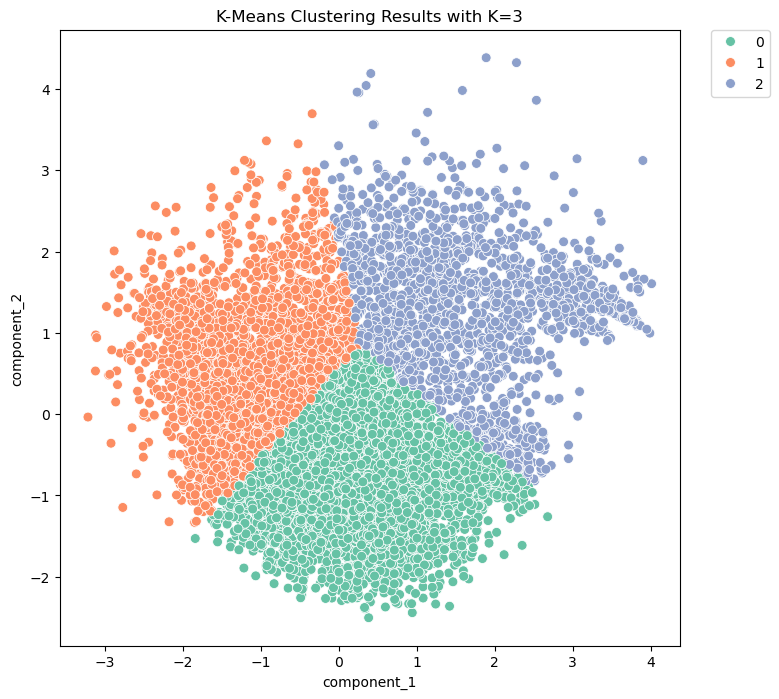

In [39]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(X_std),
    columns=["component_1", "component_2"]
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_

plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
    data=pcadf,
    x="component_1",
    y="component_2",
    s=50,
    hue="predicted_cluster",
    palette="Set2"
)

scat.set_title(
    f"K-Means Clustering Results with K=3"
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()